# Step 1: Loading the Data and Filtering for Chosen Zipcodes

**PURPOSE:** This notebook aims to suggest potential locations for investing in U.S. real estate, based on historical data on the average housing prices.
\
\
**BUSINESS PROBLEM:** The clients utilizing this notebook are people who intend to buy houses purely for investment purposes and not for residence. For this reason, in-depth considerations for each region and neighborhood are not included - only monthly price movements will be considered.
\
\
**DATA:** Data used in this notebook contains the average monthly house prices from April 1996 to April 2018 (22 year span), organized by zipcode. 
\
The dataframe contains 14722 rows and 272 columns.
\
This data can be accessed on the Zillow website (https://www.zillow.com/research/data/).

In [26]:
import pandas as pd
data = pd.read_csv('zillow_data.csv')

In [27]:
df = data
df.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


In [28]:
# user can adjust budget and maximum price range here
budget = 450 * 1000  # represents budget in dollars
price_multiple = 3  # represents the maximum amount of times of budget that the user is willing to accept

In [29]:
sr = 0.20  # Size Rank
pr = 0.20  # Price Range
cv = 0.60  # Coefficient of Variance

# formula = sr*size_rank + mp*mean_price + cv*coeff_variance

In [30]:
df['City'] = df['City'] + ', ' + df['State']

In [31]:
df.rename(columns={"City": "Location", "RegionName": "Zipcode"}, inplace=True)

In [32]:
df.drop(['RegionID', 'State', 'Metro', 'CountyName'], axis=1, inplace=True)

In [33]:
df.dropna(inplace=True)

In [34]:
df.reset_index(inplace=True)

In [35]:
df['index'] = abs(df.index - 13683) / (len(df) - 1)

In [36]:
price_deviation = df['2018-04'].map(lambda x: x / budget - 1)
price_deviation.describe()

count    13684.000000
mean        -0.346961
std          0.723791
min         -0.969333
25%         -0.695333
50%         -0.543111
75%         -0.261500
max         15.414667
Name: 2018-04, dtype: float64

In [37]:
price_deviation[price_deviation < 0] = 0

In [38]:
price_deviation.quantile(.9927)

3.0011993333332905

In [39]:
price_deviation_c = price_deviation / price_multiple

In [316]:
price_deviation_c.quantile(.9927)

1.0003997777777636

In [318]:
price_deviation_c.describe()

count    13684.000000
mean         0.041266
std          0.191771
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          5.138222
Name: 2018-04, dtype: float64

In [40]:
price_deviation_c[price_deviation_c > 1] = 1

In [41]:
price_deviation_c = abs(price_deviation_c - 1)

In [46]:
distribution = pd.DataFrame(columns=['std', 'mean', 'coeff_variance'])
# Standard deviation of average monthly prices
distribution['std'] = df.loc[:,'1996-04':'2018-04'].std(axis=1)
# Mean of average monthly prices
distribution['mean'] = df.loc[:,'1996-04':'2018-04'].mean(axis=1)
# Coefficient of Variance
distribution['coeff_variance'] = distribution['std'] / distribution['mean']

distribution.head()

,std,mean,coeff_variance
0,190821.103965,743978.867925,0.256487
1,33537.101427,219655.849057,0.152680
2,37730.794353,262110.566038,0.143950
3,231225.944628,974139.245283,0.237364
4,18167.079218,101875.471698,0.178326


In [42]:
# Calculate Return on Investment for the past 22 years (Apr 1996 - Apr 2018)
roi = (df['2018-04'] / df['1996-04']) - 1
roi

0        2.083782
1        0.365295
2        0.567966
3        1.623971
4        0.571798
           ...   
13679    1.212474
13680    1.435814
13681    1.336252
13682    2.476714
13683    1.024943
Length: 13684, dtype: float64

In [43]:
roi = pd.DataFrame(roi, index=range(len(roi)))
roi

,0
0,2.083782
1,0.365295
2,0.567966
3,1.623971
4,0.571798
...,...
13679,1.212474
13680,1.435814
13681,1.336252
13682,2.476714


In [44]:
highest_roi = roi[roi > roi.quantile(.80)].dropna().sort_values(by=0, ascending=False).index

In [47]:
size_rank = df['index']
price_range = price_deviation_c
coeff_variance = distribution['coeff_variance']

formula = sr*size_rank + pr*price_range + cv*coeff_variance

In [48]:
formula.index = range(len(formula))

In [49]:
top_choices = pd.DataFrame(formula).sort_values(0, ascending = False).index

In [50]:
final_choices = df.loc[top_choices].loc[highest_roi].head(10).index
df.loc[top_choices].loc[highest_roi].head(10)
# .loc[:,'1996-04':'2018-04']

,index,Zipcode,Location,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
114,0.991668,11211,"New York, NY",118,133200.0,132900.0,132500.0,132200.0,131800.0,131600.0,...,1405100,1406400,1424700,1435300,1440500,1463100,1496100,1531100,1581900,1623700
1137,0.916904,11222,"New York, NY",1156,149200.0,148400.0,147500.0,146600.0,146000.0,145600.0,...,1598000,1623800,1638700,1640400,1644100,1651200,1661800,1672800,1694000,1721100
466,0.965943,11216,"New York, NY",476,146100.0,146600.0,147200.0,147700.0,148400.0,149300.0,...,1452000,1506100,1553100,1567700,1559700,1545700,1540200,1553600,1578400,1598700
187,0.986333,7302,"Jersey City, NJ",192,137200.0,137800.0,138500.0,139100.0,139600.0,140100.0,...,1340200,1372300,1411000,1435900,1446300,1447800,1454900,1453900,1439500,1427300
103,0.992472,11215,"New York, NY",107,225700.0,227500.0,229400.0,231600.0,234100.0,236900.0,...,2173600,2201100,2244400,2266100,2275800,2287100,2288900,2265300,2244900,2243900
12944,0.054009,11975,"Wainscott, NY",13865,349500.0,352100.0,354900.0,358100.0,361600.0,365800.0,...,3207900,3231300,3256800,3298600,3315100,3317200,3353000,3425000,3473300,3467800
11126,0.186874,11930,"Amagansett, NY",11729,328400.0,327900.0,327100.0,325900.0,324500.0,323000.0,...,2787200,2852200,2903800,2942600,2976300,3008500,3051700,3099000,3132200,3141100
13259,0.030987,80449,"Hartsel, CO",14218,30000.0,30400.0,30900.0,31400.0,31800.0,32300.0,...,243200,244600,248000,251300,252900,254700,256600,259200,263400,267700
1762,0.871227,90291,"Los Angeles, CA",1791,234300.0,234200.0,234200.0,234200.0,234100.0,234200.0,...,1994700,2017200,2043700,2056400,2046300,2028900,2039400,2058500,2064200,2056800
253,0.981510,20001,"Washington, DC",259,92000.0,92600.0,93200.0,93900.0,94600.0,95400.0,...,765000,768800,771200,773300,777600,780500,781600,785500,791400,793300


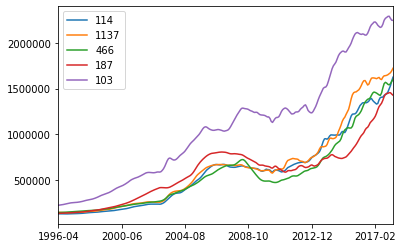

In [400]:
df.loc[top_choices].loc[highest_roi].head(5).loc[:,'1996-04':'2018-04'].T.plot()

In [51]:
metrics = pd.DataFrame()
metrics['size_rank'] = size_rank
metrics['price_range'] = price_range
metrics['coeff_variance'] = coeff_variance
metrics['formula'] = formula

In [52]:
metrics['formula'] = formula

In [53]:
metrics.loc[top_choices].head(10)

,size_rank,price_range,coeff_variance,formula
3542,0.741139,1.000000,0.597757,0.706882
28,0.997954,0.821259,0.515535,0.673163
773,0.943507,1.000000,0.468230,0.669639
656,0.952057,1.000000,0.462033,0.667631
158,0.988453,1.000000,0.448325,0.666686
300,0.978075,1.000000,0.451404,0.666457
508,0.962874,1.000000,0.452783,0.664245
253,0.981510,0.745704,0.527639,0.662026
228,0.983337,1.000000,0.435797,0.658146
673,0.950815,1.000000,0.444288,0.656736


In [54]:
metrics.loc[final_choices].head(10)

,size_rank,price_range,coeff_variance,formula
114,0.991668,0.130593,0.663802,0.622733
1137,0.916904,0.058444,0.697541,0.613594
466,0.965943,0.149111,0.672636,0.626593
187,0.986333,0.276074,0.531919,0.571633
103,0.992472,0.000000,0.560696,0.534912
12944,0.054009,0.000000,0.504669,0.313603
11126,0.186874,0.000000,0.500449,0.337645
13259,0.030987,1.000000,0.395291,0.443372
1762,0.871227,0.000000,0.553350,0.506255
253,0.981510,0.745704,0.527639,0.662026


## Brainstorming

In [107]:
import pandas as pd
data = pd.read_csv('zillow_data.csv')

In [2]:
data.head()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
1,90668,75070,McKinney,TX,Dallas-Fort Worth,Collin,2,235700.0,236900.0,236700.0,...,308000,310000,312500,314100,315000,316600,318100,319600,321100,321800
2,91982,77494,Katy,TX,Houston,Harris,3,210400.0,212200.0,212200.0,...,321000,320600,320200,320400,320800,321200,321200,323000,326900,329900
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500


Here is an article from investopedia.com, one of the most renown American financial websites that reaches 17 million US unique viewers each month:
\
https://www.investopedia.com/financial-edge/0410/the-5-factors-of-a-good-location.aspx
\
\
According to the article, 
- Homes in cities that have little room for expansion tend to be more valuable than those in cities that have plenty of room.
- Urban areas experience less severe declines and retain their values better than others.

So, as the first step, the 50 largest cities (determined by the number of zipcodes in each city) were selected.

In [77]:
largest_cities = data.groupby(['City']).count().sort_values(by='RegionName', ascending=False).head(50).index
largest_cities

Index(['New York', 'Los Angeles', 'Houston', 'San Antonio', 'Washington',
       'Chicago', 'Springfield', 'Austin', 'Philadelphia', 'Las Vegas',
       'Columbus', 'Kansas City', 'Phoenix', 'Dallas', 'Portland', 'San Diego',
       'Louisville', 'Denver', 'Oklahoma City', 'Omaha', 'Arlington',
       'Jacksonville', 'Richmond', 'San Jose', 'Fort Worth', 'Indianapolis',
       'Madison', 'Lexington', 'Lincoln', 'Charlotte', 'Franklin', 'Tucson',
       'Nashville', 'Boston', 'Wichita', 'Sacramento', 'Jackson', 'Rochester',
       'Middletown', 'Salem', 'San Francisco', 'Seattle', 'Aurora',
       'Colorado Springs', 'Monroe', 'Tulsa', 'El Paso', 'Pittsburgh',
       'Orlando', 'Cincinnati'],
      dtype='object', name='City')

However, some cities in different states had same names, thereby increasing the zipcode count overall (i.e. Washington).
\
The zipcode counts of each unique city-state pairs were found, and the above city was updated.

In [79]:
data.loc[data['City'] == 'Washington'].tail()

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
13193,64377,15938,Washington,PA,Johnstown,Cambria,13194,44900.0,45300.0,45600.0,...,69200,69200,69100,69300,69500,70000,70300,70300,70100,69900
13397,64093,15438,Washington,PA,Pittsburgh,Fayette,13398,30200.0,30300.0,30400.0,...,65700,66200,69300,71900,72300,72000,72100,73800,75300,75400
14095,60447,6794,Washington,CT,Torrington,Litchfield,14096,230500.0,230800.0,231100.0,...,486400,497300,500200,499500,498300,496300,495600,499100,504500,510500
14329,59099,3280,Washington,NH,Claremont,Sullivan,14330,84000.0,83200.0,82400.0,...,170200,170700,171400,172200,172900,173400,173900,174200,174800,175400
14355,60446,6793,Washington,CT,Torrington,Litchfield,14356,280800.0,282500.0,284300.0,...,601300,611700,616700,607200,599800,596200,594600,612000,644400,664400


In [90]:
def city_state_pairs(cities):
    pairs_dict = {}
    for city in cities:
        pairs_series = data.loc[data['City'] == city].groupby(['State']).count()['RegionName']
        for state in pairs_series.index:
            pairs_dict[str(city) + ', ' + str(state)] = pairs_series[state]
    return pairs_dict

In [101]:
pd.DataFrame.from_dict(city_state_pairs(largest_cities), orient='index', columns=['Count']).sort_values(by='Count', ascending=False).head(50)

,Count
"New York, NY",114
"Los Angeles, CA",95
"Houston, TX",86
"San Antonio, TX",47
"Chicago, IL",41
"Las Vegas, NV",38
"Austin, TX",38
"Phoenix, AZ",35
"Philadelphia, PA",35
"Dallas, TX",33


In [73]:
.data.loc[data['City'] == 'New York']['State'].nunique()

1

In [84]:
data.loc[data['City'] == 'Springfield'].groupby(['State']).count()['RegionName']

State
GA    1
IL    6
MA    9
MI    1
MO    6
NE    1
NH    1
NJ    1
OH    3
OR    2
PA    4
TN    1
VA    4
Name: RegionName, dtype: int64

In [196]:
data_lg_cities = data.loc[data['City'].isin(largest_cities)]
data_lg_cities

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14537,61054,8328,Franklin,NJ,Philadelphia,Gloucester,14538,86700.0,86800.0,87000.0,...,151700,150500,150000,151900,155600,158500,159900,161100,161700,161300
14541,59240,3846,Jackson,NH,NaN,Carroll,14542,109800.0,108700.0,107600.0,...,312000,311900,311600,311000,310600,310400,310400,311300,314400,316700
14552,81478,53911,Arlington,WI,Madison,Columbia,14553,117600.0,118700.0,119700.0,...,198600,200400,201600,205000,208300,208500,209000,209000,206900,204500
14649,59267,3875,Madison,NH,NaN,Carroll,14650,86000.0,86200.0,86400.0,...,219800,221300,222900,223500,225100,227900,229700,231400,234600,236200


In [197]:
data_lg_cities_zipcodes = data_lg_cities.SizeRank.quantile(q=0.25)
data_lg_cities_zipcodes

1437.0

In [198]:
data_lg_cities_zipcodes = data_lg_cities[data_lg_cities['SizeRank'] < data_lg_cities.SizeRank.quantile(q=0.25)]
data_lg_cities_zipcodes

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1413,61799,10459,New York,NY,New York,Bronx,1414,NaN,NaN,NaN,...,337200,334600,328700,332200,349300,370100,383000,393400,403900,410400
1425,95827,89131,Las Vegas,NV,Las Vegas,Clark,1426,163800.0,162900.0,162100.0,...,306700,309300,313300,318100,321400,324600,327700,330200,332600,334400
1427,91653,77004,Houston,TX,Houston,Harris,1428,136700.0,136300.0,136000.0,...,296400,296000,296200,297300,298800,299600,299400,300800,304000,306100
1430,92323,78227,San Antonio,TX,San Antonio,Bexar,1431,55600.0,55800.0,55900.0,...,100900,102400,103800,105700,107200,109100,111000,112600,114400,115900


In [204]:
cleaned = data_lg_cities_zipcodes.dropna()
cleaned.isna().sum().sum()
cleaned

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600
3,84616,60614,Chicago,IL,Chicago,Cook,4,498100.0,500900.0,503100.0,...,1289800,1287700,1287400,1291500,1296600,1299000,1302700,1306400,1308500,1307000
4,93144,79936,El Paso,TX,El Paso,El Paso,5,77300.0,77300.0,77300.0,...,119100,119400,120000,120300,120300,120300,120300,120500,121000,121500
5,91733,77084,Houston,TX,Houston,Harris,6,95000.0,95200.0,95400.0,...,157900,158700,160200,161900,162800,162800,162800,162900,163500,164300
6,61807,10467,New York,NY,New York,Bronx,7,152900.0,152700.0,152600.0,...,394400,400000,407300,411600,413200,414300,413900,411400,413200,417900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1397,96038,90057,Los Angeles,CA,Los Angeles-Long Beach-Anaheim,Los Angeles,1398,131600.0,131500.0,131400.0,...,639600,650500,659600,667700,677400,687100,692500,706100,735600,762500
1402,67187,22202,Arlington,VA,Washington,Arlington,1403,269500.0,269000.0,268400.0,...,816300,816600,820500,824900,825400,824000,824200,833200,852900,869100
1425,95827,89131,Las Vegas,NV,Las Vegas,Clark,1426,163800.0,162900.0,162100.0,...,306700,309300,313300,318100,321400,324600,327700,330200,332600,334400
1427,91653,77004,Houston,TX,Houston,Harris,1428,136700.0,136300.0,136000.0,...,296400,296000,296200,297300,298800,299600,299400,300800,304000,306100


In [205]:
cleaned.loc[:,'1996-04':'2018-04'].std(axis=1)

0       190821.103965
3       231225.944628
4        18167.079218
5        17242.109812
6        85699.140581
            ...      
1397    173907.504514
1402    189174.341499
1425     79974.029711
1427     36052.492581
1430     12629.717591
Length: 388, dtype: float64

In [117]:
queens = data.loc[data['City'] == 'New York'].loc[data['CountyName'] == 'Queens'].iloc[:6]

In [127]:
queens = queens.drop(['RegionID', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], axis=1).set_index('RegionName').T

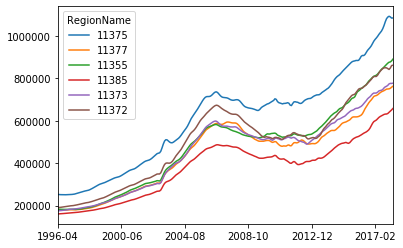

In [128]:
queens.plot();

# Step 2: Data Preprocessing

In [55]:
def get_datetimes(df):
    return pd.to_datetime(df.index.values[1:], format='%Y-%m')

In [56]:
best_five = df.loc[final_choices].head().drop(['index', 'Location', 'SizeRank'], axis=1).set_index('Zipcode').T
best_five

Zipcode,11211,11222,11216,7302,11215
1996-04,133200.0,149200.0,146100.0,137200.0,225700.0
1996-05,132900.0,148400.0,146600.0,137800.0,227500.0
1996-06,132500.0,147500.0,147200.0,138500.0,229400.0
1996-07,132200.0,146600.0,147700.0,139100.0,231600.0
1996-08,131800.0,146000.0,148400.0,139600.0,234100.0
...,...,...,...,...,...
2017-12,1463100.0,1651200.0,1545700.0,1447800.0,2287100.0
2018-01,1496100.0,1661800.0,1540200.0,1454900.0,2288900.0
2018-02,1531100.0,1672800.0,1553600.0,1453900.0,2265300.0
2018-03,1581900.0,1694000.0,1578400.0,1439500.0,2244900.0


In [417]:
get_datetimes(best_five)

DatetimeIndex(['1996-05-01', '1996-06-01', '1996-07-01', '1996-08-01',
               '1996-09-01', '1996-10-01', '1996-11-01', '1996-12-01',
               '1997-01-01', '1997-02-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=264, freq=None)

In [418]:
best_five.index = pd.to_datetime(best_five.index)

In [419]:
best_five.index

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

DatetimeIndex(['1996-04-01', '1996-05-01', '1996-06-01', '1996-07-01',
               '1996-08-01', '1996-09-01', '1996-10-01', '1996-11-01',
               '1996-12-01', '1997-01-01',
               ...
               '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01',
               '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01',
               '2018-03-01', '2018-04-01'],
              dtype='datetime64[ns]', length=265, freq=None)

# Step 3: EDA and Visualization

In [142]:
import matplotlib.pyplot as plt

In [143]:
from statsmodels.tsa.stattools import adfuller

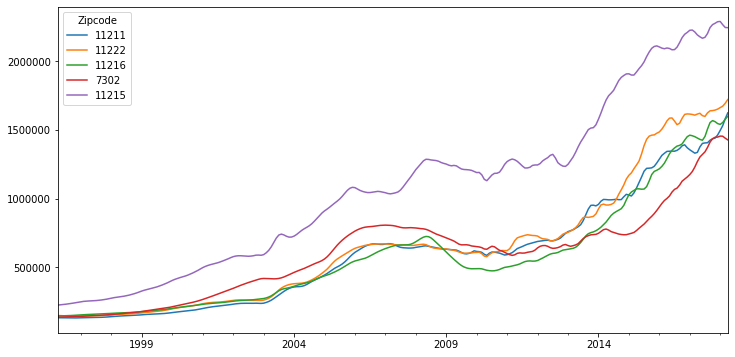

In [423]:
best_five.plot(figsize=(12,6));

In [191]:
def dftest_results(data):
    Dickey_Fuller = {}
    for zipcode in data:
        dftest = adfuller(data[zipcode])
        Dickey_Fuller[zipcode] = dftest[0:4]
    DF_Test = pd.DataFrame.from_dict(Dickey_Fuller)
    DF_Test.index = ['Test Statistic', 'p-value', '#Lags Used', '#Observations Used']
    return DF_Test

In [424]:
dftest_results(best_five)

,11211,11222,11216,7302,11215
Test Statistic,1.988403,1.024405,0.203156,-0.549950,0.464626
p-value,0.998658,0.994517,0.972438,0.881895,0.983757
#Lags Used,15.000000,16.000000,16.000000,16.000000,16.000000
#Observations Used,249.000000,248.000000,248.000000,248.000000,248.000000


In [473]:
best_five

Zipcode,11211,11222,11216,7302,11215
1996-04-01,133200.0,149200.0,146100.0,137200.0,225700.0
1996-05-01,132900.0,148400.0,146600.0,137800.0,227500.0
1996-06-01,132500.0,147500.0,147200.0,138500.0,229400.0
1996-07-01,132200.0,146600.0,147700.0,139100.0,231600.0
1996-08-01,131800.0,146000.0,148400.0,139600.0,234100.0
...,...,...,...,...,...
2017-12-01,1463100.0,1651200.0,1545700.0,1447800.0,2287100.0
2018-01-01,1496100.0,1661800.0,1540200.0,1454900.0,2288900.0
2018-02-01,1531100.0,1672800.0,1553600.0,1453900.0,2265300.0
2018-03-01,1581900.0,1694000.0,1578400.0,1439500.0,2244900.0


In [467]:
best_five[11211].iloc[0]

133200.0

In [474]:
len(best_five.columns)

5

In [484]:
# Monthly returns for each zipcode
returns = pd.DataFrame()
for zipcode in best_five.columns:
    returns[zipcode] = (best_five[zipcode].shift(periods=1) / best_five[zipcode]) - 1

In [489]:
returns.dropna(inplace=True)

,11211,11222,11216,7302,11215
Test Statistic,-2.845357,-2.742244,-2.275457,-1.815001,-2.734080
p-value,0.052081,0.067009,0.180006,0.373040,0.068324
#Lags Used,15.000000,14.000000,16.000000,14.000000,16.000000
#Observations Used,248.000000,249.000000,247.000000,249.000000,247.000000


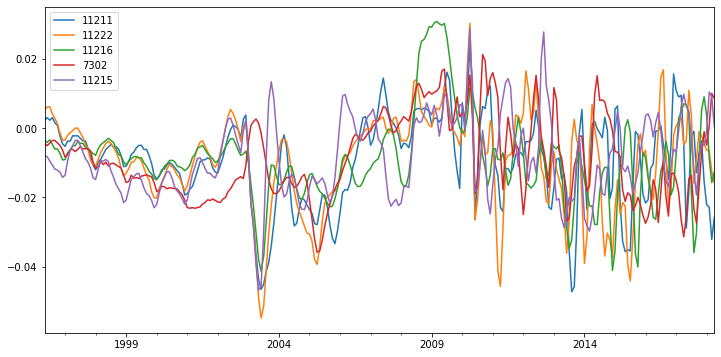

In [490]:
returns.plot(figsize=(12,6));
dftest_results(returns)

In [ ]:
# create new notebook - final model
# build a final model for each - add 1 to differencing
# feed in undifferenced monthly returns
# RMSE would be RMSE of monthly returns.
# Loops to get to original dollar values.

# returns df into autoarima
# DF, PACF provides starting point (pdq to start)
# 1 or 2 below pdq that you got from eda

,11211,11222,11216,7302,11215
Test Statistic,-6.520122e+00,-6.860757e+00,-4.949550,-6.604221e+00,-4.780046
p-value,1.047252e-08,1.604808e-09,0.000028,6.618658e-09,0.000059
#Lags Used,1.300000e+01,1.300000e+01,15.000000,1.300000e+01,16.000000
#Observations Used,2.490000e+02,2.490000e+02,247.000000,2.490000e+02,246.000000


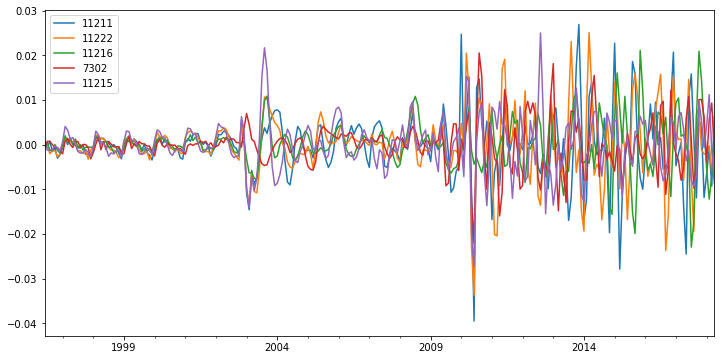

In [493]:
diff_returns = (returns).diff(periods=1).dropna()
diff_returns.plot(figsize=(12,6))a;
dftest_results(diff_returns)

In [521]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [534]:
def corr_graphs(df):
    #Create figure
    fig,(ax1,ax2) = plt.subplots(2,1,figsize=(12,8))
    print('Zipcode ' + str(df.name))
    #Make ACF plot
    plot_acf(df, ax=ax1)
    #Make PACF plot
    plot_pacf(df, ax=ax2)
    plt.show()

Zipcode 11211


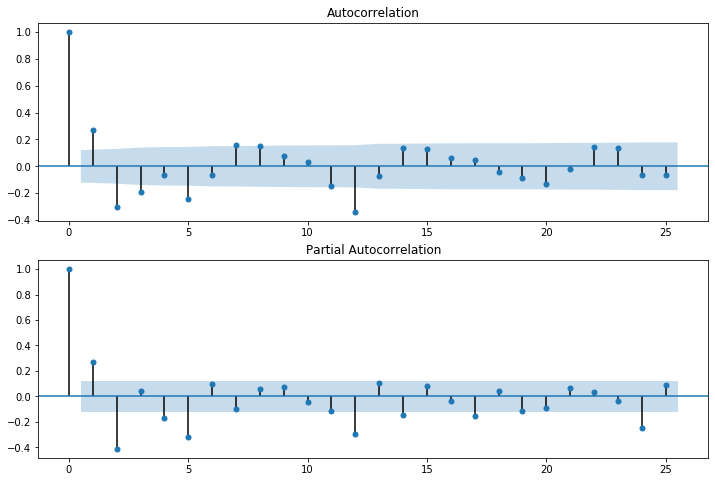

Zipcode 11222


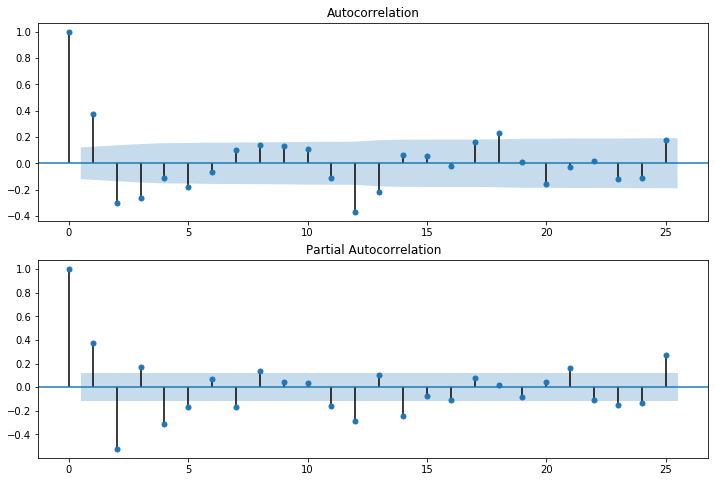

Zipcode 11216


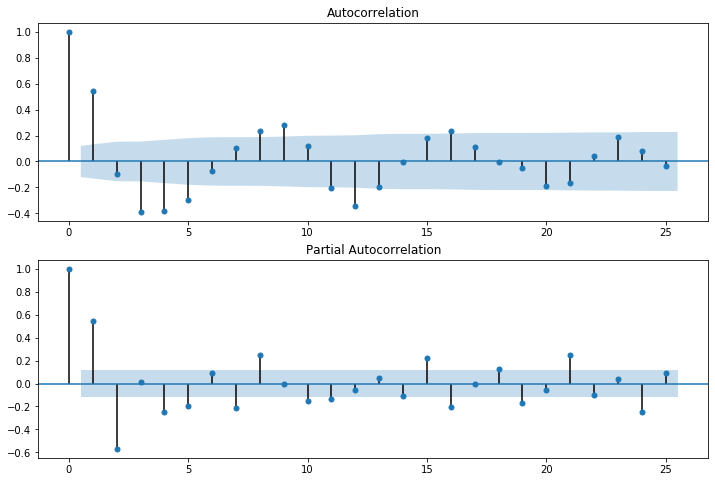

Zipcode 7302


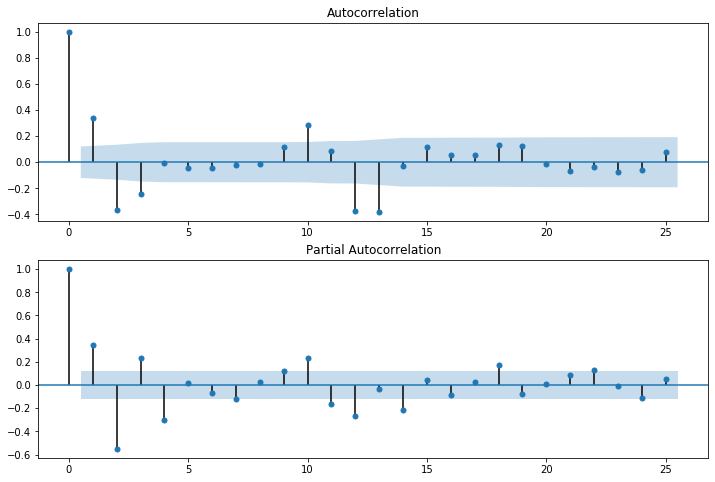

Zipcode 11215


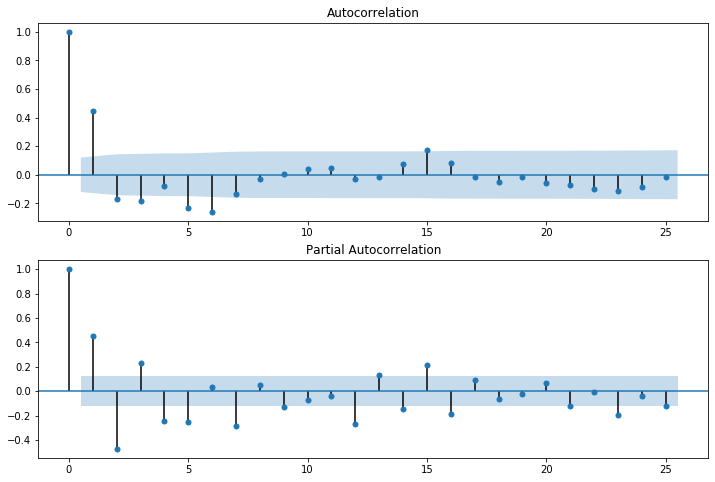

In [535]:
for cols in diff_returns:
    corr_graphs(diff_returns[cols])

## Brainstorming

,11211,11222,11216,7302,11215
Test Statistic,-0.844404,-1.031324,-0.738008,-1.822046,-2.342002
p-value,0.805729,0.741669,0.836657,0.369572,0.158779
#Lags Used,15.000000,15.000000,16.000000,15.000000,16.000000
#Observations Used,249.000000,249.000000,248.000000,249.000000,248.000000


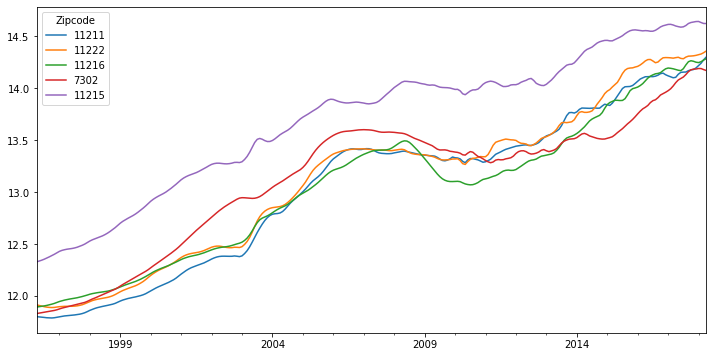

In [457]:
log_best_five = np.log(best_five)
log_best_five.plot(figsize=(12,6));
dftest_results(log_best_five)

,11211,11222,11216,7302,11215
Test Statistic,-2.849206,-2.742197,-2.258584,-1.820324,-2.747316
p-value,0.051582,0.067017,0.185674,0.370419,0.066202
#Lags Used,15.000000,14.000000,16.000000,14.000000,16.000000
#Observations Used,248.000000,249.000000,247.000000,249.000000,247.000000


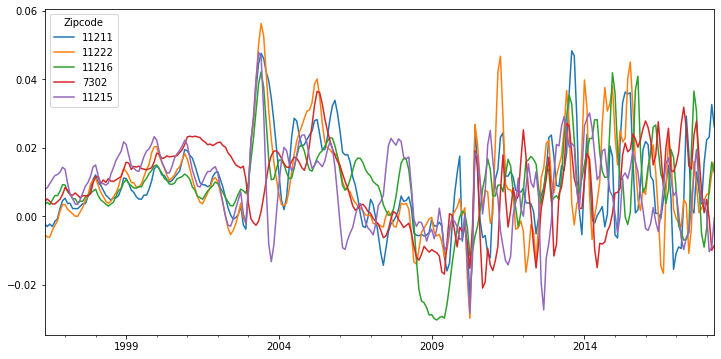

In [492]:
diff_log_best_five = (log_best_five).diff(periods=1).dropna()
diff_log_best_five.plot(figsize=(12,6));
dftest_results(diff_log_best_five)

,11211,11222,11216,7302,11215
Test Statistic,-2.295795,-2.415135,-2.108813,-2.026129,-2.607536
p-value,0.173328,0.137510,0.240986,0.275235,0.091450
#Lags Used,16.000000,15.000000,16.000000,15.000000,16.000000
#Observations Used,247.000000,248.000000,247.000000,248.000000,247.000000


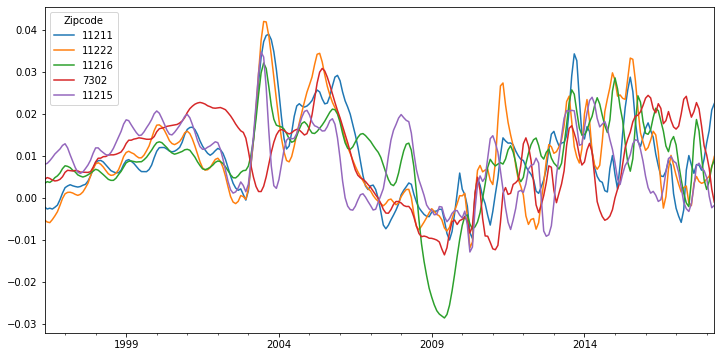

In [458]:
ewma_diff_log_best_five = (diff_log_best_five).ewm(halflife=2).mean()
ewma_diff_log_best_five.plot(figsize=(12,6));
dftest_results(ewma_diff_log_best_five)

# Step 4: Reshape from Wide to Long Format

In [ ]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionName', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

# Step 5: ARIMA Modeling

In [60]:
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

In [538]:
tts_cutoff = round(len(diff_returns) * 0.80)
train, test = diff_returns.iloc[:tts_cutoff], diff_returns.iloc[tts_cutoff:]

In [537]:
diff_returns.columns

Int64Index([11211, 11222, 11216, 7302, 11215], dtype='int64')

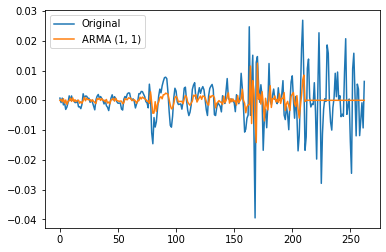

(0.005543081213547752, 0.010492653771327184)

In [606]:
arma1 = ARIMA(train.iloc[:,0], order=(1,0,1), freq='MS').fit()
trainpreds1 = pd.DataFrame(np.array(arma1.predict()), index=train.index)
testpreds1 = pd.DataFrame(arma1.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,0]), label='Original')
plt.plot(np.append(trainpreds1, testpreds1[0]), label='ARMA (1, 1)')
plt.legend()
plt.show()

train1_rmse = mean_squared_error(train.iloc[:,0], trainpreds1)**0.5
test1_rmse = mean_squared_error(test.iloc[:,0], testpreds1)**0.5
train1_rmse, test1_rmse

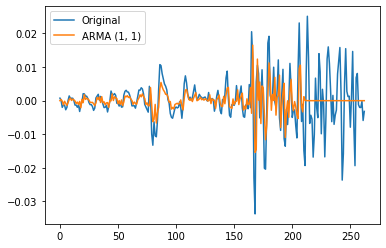

(0.00577149235995284, 0.010530692378744572)

In [608]:
arma2 = ARIMA(train.iloc[:,1], order=(1,0,1), freq='MS').fit()
trainpreds2 = pd.DataFrame(np.array(arma2.predict()), index=train.index)
testpreds2 = pd.DataFrame(arma2.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,1]), label='Original')
plt.plot(np.append(trainpreds2, testpreds2[0]), label='ARMA (1, 1)')
plt.legend()
plt.show()

train2_rmse = mean_squared_error(train.iloc[:,0], trainpreds2)**0.5
test2_rmse = mean_squared_error(test.iloc[:,0], testpreds2)**0.5
train2_rmse, test2_rmse

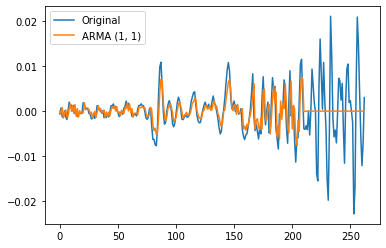

(0.002463042525709082, 0.009459107599522518)

In [609]:
arma3 = ARIMA(train.iloc[:,2], order=(1,0,1), freq='MS').fit()
trainpreds3 = pd.DataFrame(np.array(arma3.predict()), index=train.index)
testpreds3 = pd.DataFrame(arma3.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,2]), label='Original')
plt.plot(np.append(trainpreds3, testpreds3[0]), label='ARMA (1, 1)')
plt.legend()
plt.show()

train3_rmse = mean_squared_error(train.iloc[:,2], trainpreds3)**0.5
test3_rmse = mean_squared_error(test.iloc[:,2], testpreds3)**0.5
train3_rmse, test3_rmse

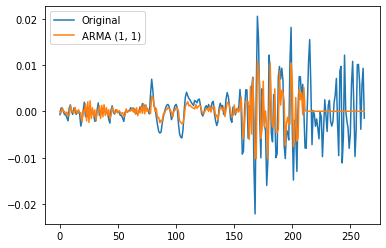

(0.003753078591741148, 0.006441765118228856)

In [610]:
arma4 = ARIMA(train.iloc[:,3], order=(1,0,1), freq='MS').fit()
trainpreds4 = pd.DataFrame(np.array(arma4.predict()), index=train.index)
testpreds4 = pd.DataFrame(arma4.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,3]), label='Original')
plt.plot(np.append(trainpreds4, testpreds4[0]), label='ARMA (1, 1)')
plt.legend()
plt.show()

train4_rmse = mean_squared_error(train.iloc[:,3], trainpreds4)**0.5
test4_rmse = mean_squared_error(test.iloc[:,3], testpreds4)**0.5
train4_rmse, test4_rmse

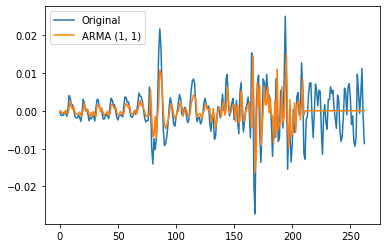

(0.004672471613708202, 0.005820898442487382)

In [611]:
arma5 = ARIMA(train.iloc[:,4], order=(1,0,1), freq='MS').fit()
trainpreds5 = pd.DataFrame(np.array(arma5.predict()), index=train.index)
testpreds5 = pd.DataFrame(arma5.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,4]), label='Original')
plt.plot(np.append(trainpreds5, testpreds5[0]), label='ARMA (1, 1)')
plt.legend()
plt.show()

train5_rmse = mean_squared_error(train.iloc[:,4], trainpreds5)**0.5
test5_rmse = mean_squared_error(test.iloc[:,4], testpreds5)**0.5
train5_rmse, test5_rmse

In [620]:
diff_returns.columns

Int64Index([11211, 11222, 11216, 7302, 11215], dtype='int64')

In [575]:
# !pip install pmdarima

In [576]:
from pmdarima.arima import auto_arima

In [580]:
autoarima_params = {}

for col in diff_returns.columns:
    auto = auto_arima(diff_returns[col], max_order=None, start_p=1, start_q=1, 
                      max_p=10, max_q=10, max_d=5, seasonal=False)   
    autoarima_params[col] = auto.get_params()['order']

In [581]:
autoarima_params

{11211: (0, 0, 5),
 11222: (5, 0, 1),
 11216: (2, 0, 0),
 7302: (0, 0, 3),
 11215: (5, 0, 4)}

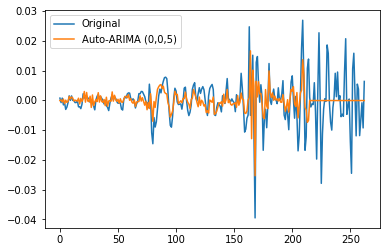

(0.004660212948292422, 0.01076915065599195)

In [612]:
auto1 = ARIMA(train.iloc[:,0], order=autoarima_params[11211], freq='MS').fit()
a_trainpreds1 = pd.DataFrame(np.array(auto1.predict()), index=train.index)
a_testpreds1 = pd.DataFrame(auto1.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,0]), label='Original')
plt.plot(np.append(a_trainpreds1, a_testpreds1[0]), label='Auto-ARIMA (0,0,5)')
plt.legend()
plt.show()

a_train1_rmse = mean_squared_error(train.iloc[:,0], a_trainpreds1)**0.5
a_test1_rmse = mean_squared_error(test.iloc[:,0], a_testpreds1)**0.5
a_train1_rmse, a_test1_rmse

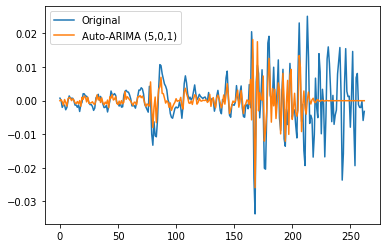

(0.0044764956841946025, 0.0104643429091325)

In [613]:
auto2 = ARIMA(train.iloc[:,1], order=autoarima_params[11222], freq='MS').fit()
a_trainpreds2 = pd.DataFrame(np.array(auto2.predict()), index=train.index)
a_testpreds2 = pd.DataFrame(auto2.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,1]), label='Original')
plt.plot(np.append(a_trainpreds2, a_testpreds2[0]), label='Auto-ARIMA (5,0,1)')
plt.legend()
plt.show()

a_train2_rmse = mean_squared_error(train.iloc[:,1], a_trainpreds2)**0.5
a_test2_rmse = mean_squared_error(test.iloc[:,1], a_testpreds2)**0.5
a_train2_rmse, a_test2_rmse

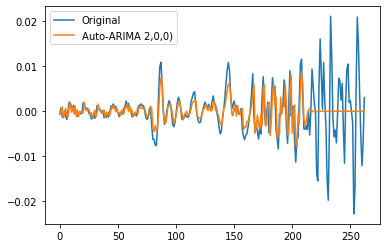

(0.0024039846039167687, 0.009423114499128086)

In [614]:
auto3 = ARIMA(train.iloc[:,2], order=autoarima_params[11216], freq='MS').fit()
a_trainpreds3 = pd.DataFrame(np.array(auto3.predict()), index=train.index)
a_testpreds3 = pd.DataFrame(auto3.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,2]), label='Original')
plt.plot(np.append(a_trainpreds3, a_testpreds3[0]), label='Auto-ARIMA 2,0,0)')
plt.legend()
plt.show()

a_train3_rmse = mean_squared_error(train.iloc[:,2], a_trainpreds3)**0.5
a_test3_rmse = mean_squared_error(test.iloc[:,2], a_testpreds3)**0.5
a_train3_rmse, a_test3_rmse

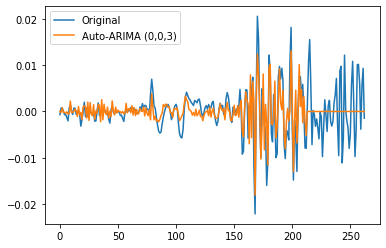

(0.003317223725517227, 0.006288091857031356)

In [615]:
auto4 = ARIMA(train.iloc[:,3], order=autoarima_params[7302], freq='MS').fit()
a_trainpreds4 = pd.DataFrame(np.array(auto4.predict()), index=train.index)
a_testpreds4 = pd.DataFrame(auto4.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,3]), label='Original')
plt.plot(np.append(a_trainpreds4, a_testpreds4[0]), label='Auto-ARIMA (0,0,3)')
plt.legend()
plt.show()

a_train4_rmse = mean_squared_error(train.iloc[:,3], a_trainpreds4)**0.5
a_test4_rmse = mean_squared_error(test.iloc[:,3], a_testpreds4)**0.5
a_train4_rmse, a_test4_rmse

/Users/taejoon/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/base/model.py:548: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


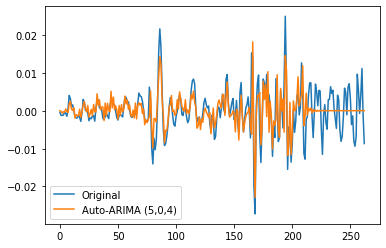

(0.0037541022865996425, 0.005733597451328089)

In [616]:
auto5 = ARIMA(train.iloc[:,4], order=autoarima_params[11215], freq='MS').fit()
a_trainpreds5 = pd.DataFrame(np.array(auto5.predict()), index=train.index)
a_testpreds5 = pd.DataFrame(auto5.forecast(len(test))[0], index=test.index)

plt.plot(np.array(diff_returns.iloc[:,4]), label='Original')
plt.plot(np.append(a_trainpreds5, a_testpreds5[0]), label='Auto-ARIMA (5,0,4)')
plt.legend()
plt.show()

a_train5_rmse = mean_squared_error(train.iloc[:,4], a_trainpreds5)**0.5
a_test5_rmse = mean_squared_error(test.iloc[:,4], a_testpreds5)**0.5
a_train5_rmse, a_test5_rmse

# Step 6: Interpreting Results

In [625]:
rmse

,11211,11222,11216,7302,11215
Train RMSE,NaN,NaN,NaN,NaN,NaN
Test RMSE,NaN,NaN,NaN,NaN,NaN


In [629]:
print(a_train1_rmse, a_test1_rmse)
print(a_train2_rmse, a_test2_rmse)
print(a_train3_rmse, a_test3_rmse)
print(a_train4_rmse, a_test4_rmse)
print(a_train5_rmse, a_test5_rmse)

0.004660212948292422 0.01076915065599195
0.0044764956841946025 0.0104643429091325
0.0024039846039167687 0.009423114499128086
0.003317223725517227 0.006288091857031356
0.0037541022865996425 0.005733597451328089


In [634]:
print(a_testpreds1.mean())
print(a_testpreds2.mean())
print(a_testpreds3.mean())
print(a_testpreds4.mean())
print(a_testpreds5.mean())

0   -0.000257
dtype: float64
0   -0.000068
dtype: float64
0   -0.000183
dtype: float64
0   -0.000084
dtype: float64
0    0.000031
dtype: float64


Best zipcode to invest is the fifth zipcode - it has the lowest test RMSE and the third lowest train RMSE. It also has the highest average predicted growth out of the five top zipcodes.

11215 is the zipcode for Park Slope, located in Brooklyn, NY.

In [2]:
## need to interpret the coefficients and undiff twice...

In [4]:
def arima_cross_validation(data, order, initial=12*15, horizon=12, period=6, verbose=False):
    k = (len(data)-initial-horizon)//period
    if verbose: print('Cross validating over', str(k), 'folds.')
    
    rmses = []
    for i in range(1, k+1):
        n = len(data)-horizon-((k-i)*period)
        model = ARIMA(data[:n], order=order, freq='MS').fit()
        y_hat = model.get_forecast(steps=horizon).predicted_mean.to_numpy()
        y = data[n:n+horizon].to_numpy()
        rmse = np.sqrt(mean_squared_error(y, y_hat))
        if verbose: print(f'fold {i}: train[0:{n}], test[{n}:{n+horizon}] of {len(data)}, rmse={rmse}')
        rmses.append(rmse)

    return rmses

def arima_analyze(data, order, initial=12*15, horizon=12, period=6, forecast_length=24, filename=None):
    
    forecast_index = pd.date_range(data.index[-1], periods=forecast_length+1, freq='MS')[1:]
    forecast_df = pd.DataFrame(index=forecast_index)
    
    n = len(data.columns)
    rows, cols = -(-n//2), (1+(n>1))
    fig = plt.figure(figsize=(10*cols, 6*rows))
    axs = fig.subplots(rows, cols, squeeze=False).flatten()
    
    for i, col in enumerate(data.columns):
        #cross-validation to get rmse
        rmses = arima_cross_validation(data=data[col], order=order, initial=initial, horizon=horizon, period=period)
        rmse = sum(rmses)/len(rmses)
        
        #run model to get 1-year forecast
        model = ARIMA(data[col], order=order, freq='MS').fit()
        prediction_results = model.get_prediction(start=2, typ='levels')
        prediction = prediction_results.predicted_mean
        prediction_conf_int = prediction_results.conf_int(alpha=0.2)
        prediction_lower = prediction_conf_int[f'lower {col}'].tolist()
        prediction_upper = prediction_conf_int[f'upper {col}'].tolist()
        
        forecast_results = model.get_forecast(steps=forecast_length)
        forecast = forecast_results.predicted_mean
        forecast_df[col] = forecast
        forecast_conf_int = forecast_results.conf_int(alpha=0.2)
        forecast_lower = forecast_conf_int[f'lower {col}'].tolist()
        forecast_upper = forecast_conf_int[f'upper {col}'].tolist()
        
        #plot data with forecast
        ax = axs[i]
        ax.plot(data.index, data[col], 'k.')
        ax.plot(data.index[-len(prediction):], prediction, ls='-', c='#0072B2')
        ax.plot(forecast_index, forecast, ls='-', c='#0072B2')
        ax.fill_between(prediction.index, prediction_lower, prediction_upper, color='#0072B2', alpha=0.2)
        ax.fill_between(forecast_index, forecast_lower, forecast_upper, color='#0072B2', alpha=0.2)
        ax.set_title(f'{col}, rmse: {int(rmse)}')
        ax.legend(labels=['actual', 'model'], loc='upper left')
    
    if i>1:
        plt.suptitle('ARIMA Models', y=1.03, fontsize=30)
    plt.tight_layout()
    if filename:
        plt.savefig(f'visualizations/{filename}.png')
    plt.show()
    
    return forecast_df

In [62]:
import matplotlib.pyplot as plt
plt.style.use('seaborn')
plt.style.use('seaborn-talk')
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [67]:
best_five.index = pd.to_datetime(best_five.index)

LinAlgError: LU decomposition error.

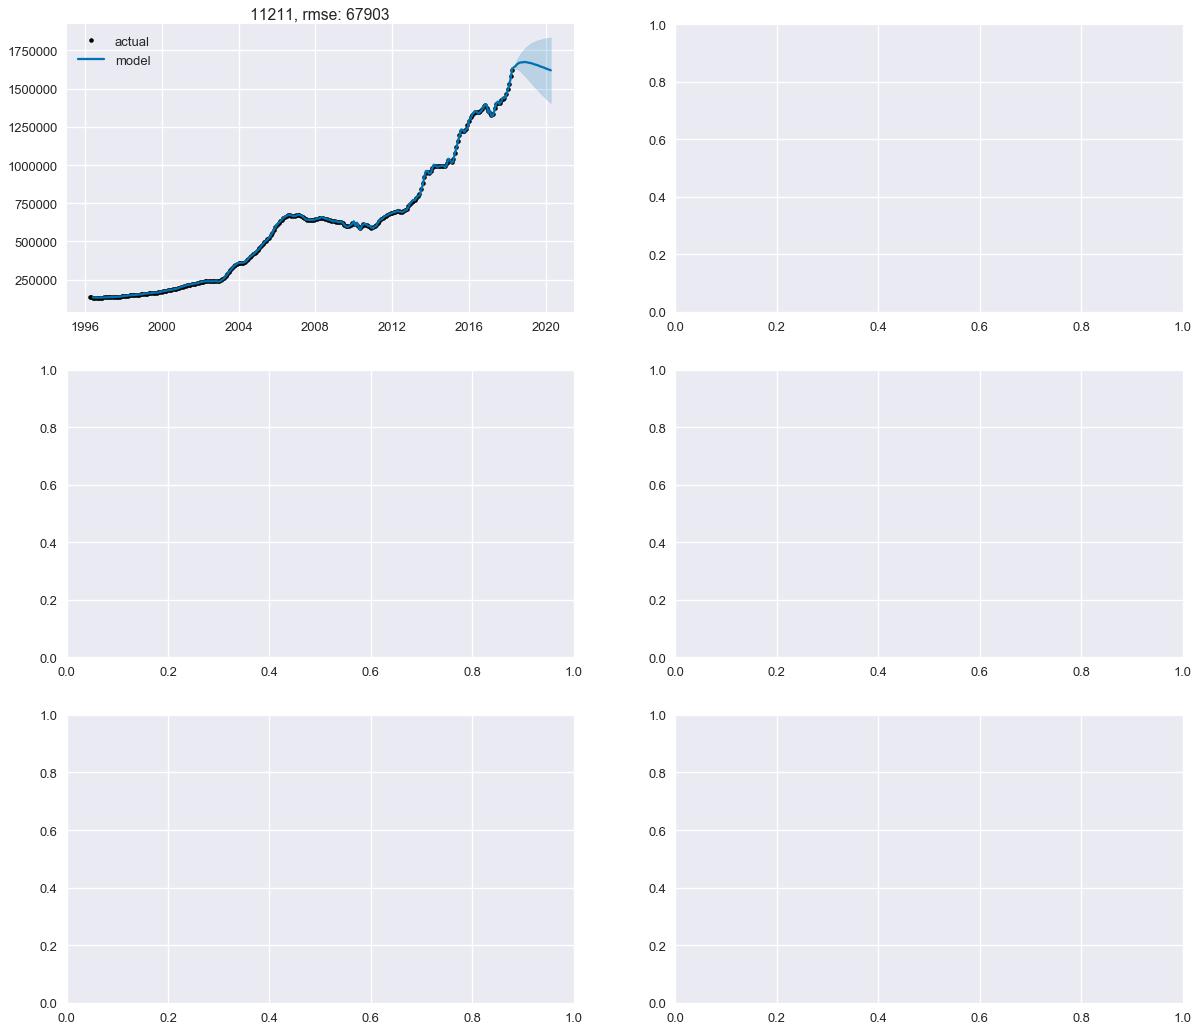

In [68]:
arima_analyze(best_five, (5,0,5))

In [3]:
## model interpretations and graphical representation needed

In [ ]:
## print figures accordingly and include in readme